In [1]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import v2
import torch.nn.functional as F

import copy
import os

from tqdm import tqdm

import sys
sys.path.append('utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
data_path = '/scratch/cm6627/diffeo_cnn/experiment/007_ViT/data/'

In [62]:
data = t.load(data_path + 'ViT_SmallerDiffeos.pt', map_location = t.device('cpu')).reshape(12, 14, 20, 197, 768)
class_token = data[:,:,:,0,:]

In [17]:
ViT = tv.models.vit_b_16(weights=tv.models.ViT_B_16_Weights)
ViT.eval();
for param in ViT.parameters():
    param.requires_grad = False

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def load_dataset():
    path = '/vast/xj2173/diffeo/imagenet'
    transform = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor()
    ])
    dataset = tv.datasets.ImageNet(path, 
                                            split='val', 
                                            transform=transform)
    return dataset

dataset = load_dataset()
test_data = dataset[0][0].unsqueeze(0)

In [70]:
norm_class_token = F.normalize(class_token, dim = 3)
ref = norm_class_token[:,0,1,:]

In [71]:
result = t.einsum('lsdp, lp -> lsd', norm_class_token, ref).mean(2)

In [72]:
diffeo_strength_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

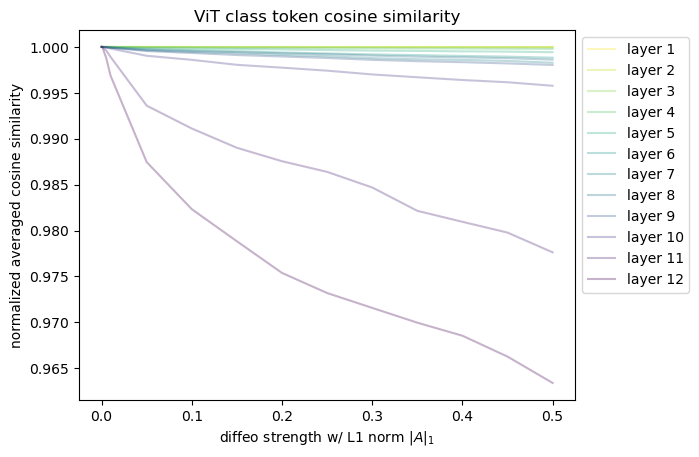

In [74]:
import numpy as np

plt.figure()

colors = plt.cm.viridis_r(np.linspace(0,1,len(result)))

for i, cos_sim in enumerate(result):
    layer_num = i+1
    plt.plot(diffeo_strength_list, cos_sim, color=colors[i], label = f'layer {layer_num}', alpha = 0.3)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel(r'diffeo strength w/ L1 norm $|A|_1$')
    plt.title(r'ViT class token cosine similarity')
    plt.ylabel(r'normalized averaged cosine similarity')

In [75]:
ref.shape

torch.Size([12, 768])

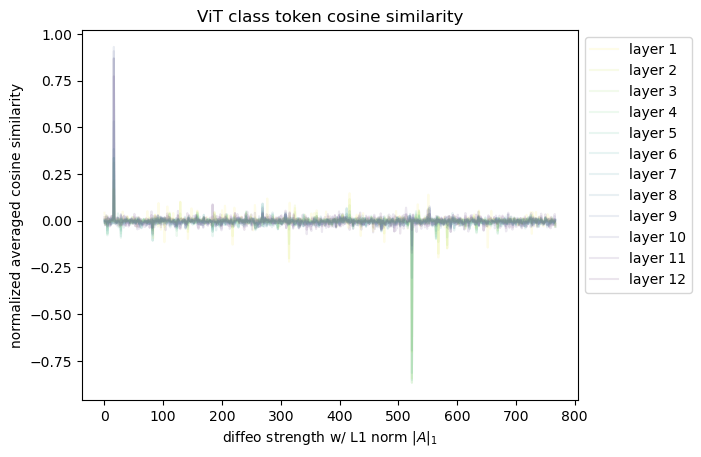

In [84]:
import numpy as np

plt.figure()

colors = plt.cm.viridis_r(np.linspace(0,1,len(result)))

for i, activation in enumerate(ref):
    layer_num = i+1
    plt.plot(activation, color=colors[i], label = f'layer {layer_num}', alpha = 0.1)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel(r'diffeo strength w/ L1 norm $|A|_1$')
    plt.title(r'ViT class token cosine similarity')
    plt.ylabel(r'normalized averaged cosine similarity')